In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir(r'/content/drive/MyDrive/Colab Notebooks/1512/Project_A_Supp')  # Change the directory to torchRay-master folder

# Requirements

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import cv2

from xai_utils import *

from keras import layers
from keras import activations
%load_ext tensorboard
import datetime
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Dataset loader

In [4]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/1512/Project_A_Supp/hmt_dataset/HMT_train' #you should change to your directory
test_dir = '/content/drive/MyDrive/Colab Notebooks/1512/Project_A_Supp/hmt_dataset/HMT_test' #you should change to your directory

train_datagen = ImageDataGenerator(rescale=1/255.,
shear_range=0.1,
rotation_range=15,
horizontal_flip=True,
vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=32,
shuffle=False)

Found 4504 images belonging to 8 classes.
Found 496 images belonging to 8 classes.


Overrided

# Create Model

In [5]:
weight_decay = 5e-4
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten?

#model.add(Flatten())
model.add(GlobalAveragePooling2D())
#model.add(Dense(1024, activation='relu', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
#                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(8, activation='softmax', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                    

# Training

In [ ]:
# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.SGD(),
              metrics=['accuracy'])

In [ ]:
def lr_scheduler(epoch):
    base_ep = 15
    return 1e-3 * (.5 ** (epoch // base_ep))
lr_reduce_cb = keras.callbacks.LearningRateScheduler(lr_scheduler)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir='log2', write_graph=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, min_delta=0.)

In [ ]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.n // 32,
                    epochs=150,
                    callbacks=[tensorboard_cb],                  
                    shuffle = True,
                    verbose=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/150
140/140 [==============================] - 845s 6s/step - loss: 1.9248 - accuracy: 0.2619
Epoch 2/150
140/140 [==============================] - 82s 583ms/step - loss: 1.5650 - accuracy: 0.3808
Epoch 3/150
140/140 [==============================] - 81s 581ms/step - loss: 1.3551 - accuracy: 0.4642
Epoch 4/150
140/140 [==============================] - 78s 554ms/step - loss: 1.2167 - accuracy: 0.5302
Epoch 5/150
140/140 [==============================] - 79s 561ms/step - loss: 1.1287 - accuracy: 0.5543
Epoch 6/150
140/140 [==============================] - 76s 545ms/step - loss: 1.1076 - accuracy: 0.5836
Epoch 7/150
140/140 [==============================] - 78s 554ms/step - loss: 1.0797 - accuracy: 0.5970
Epoch 8/150
140/140 [==============================] - 77s 548ms/step - loss: 1.0484 - accuracy: 0.6131
Epoch 9/150
140/140 [==============================] - 78s 556ms/step - loss: 1.0171 - accuracy: 0.6221
Epoch 10/150
140/140 [==============================] - 76s 539ms/

In [ ]:
model.save('HMT.h5')

# Load Model

In [6]:
# model=load_model('/content/drive/MyDrive/Colab Notebooks/1512/Project_A_Supp/models/HMT.h5')
model=load_model('/content/drive/MyDrive/Colab Notebooks/1512/Project_A_Supp/HMT.h5')

In [ ]:
# def my_summary_iterator(path):
#   for r in tf_record.tf_record_iterator(path):
#     yield event_pb2.Event.FromString(r)
# train_acc = []
# train_loss = []
# train_lr = []
# #print('log/train/' + os.listdir('log/train')[2])
# for e in my_summary_iterator('log/train/' + os.listdir('log/train')[-1]):
#   for v in e.summary.value:
#     if v.tag == 'epoch_accuracy':
#       train_acc.append(v.simple_value)
#     elif v.tag == 'epoch_loss':
#       train_loss.append(v.simple_value)

In [ ]:
# plt.plot(np.arange(len(train_acc)), train_acc)
# plt.xlabel('Epoch')
# plt.ylabel('Training Accuracy')
# plt.title('Training progress: Accuracy')

In [ ]:
# plt.plot(np.arange(len(train_loss)), train_loss)
# plt.xlabel('Epoch')
# plt.ylabel('Training Loss')
# plt.title('Training progress: Loss')

# Explanation

Load the explaier library

In [10]:
from xai_utils import *

Load a batch of images

In [11]:
test_generator.reset()

In [12]:
image_batch,label_batch=test_generator.next()

Classes:

In [13]:
classes=['Tumor', 'Stroma', 'Complex', 'Lympho', 'Debris', 'Mucosa', 'Adiopse', 'Empty']

Predict a single image

In [14]:
index=16

In [15]:
prediction=model(image_batch)
print('True label: '+classes[np.argmax(label_batch[index])])
print('Predicted_label: '+classes[np.argmax(prediction[index])])
print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))

True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.9097167


In [36]:
print('My 3.b:')
train_score = 0.
train_acc = 0.
train_generator.reset()
for i in range(100):
    image_batch,label_batch=train_generator.next()
    if(i==0):
        t_label_batch = label_batch
        prediction_prob=model(image_batch)
    else:
        t_label_batch = np.append(t_label_batch,label_batch,axis=0)
        prediction_prob = np.append(prediction_prob,model(image_batch),axis=0)
    score, acc = model.evaluate(image_batch, label_batch)
    train_score += score
    train_acc += acc
train_score /= (100)
train_acc /= (100)
print('Train score:', train_score)
print('Train accuracy:', train_acc)

My 3.b:
1/1 [==============================] - 2s 2s/step - loss: 0.6696 - accuracy: 0.7188
Train score: 0.5818344122171402
Train accuracy: 0.8359375


In [16]:
print('My 3.b:')
# y_test_onehot = tensorflow.keras.utils.to_categorical(y_test, 10)
t_score = 0.
t_acc = 0.
test_generator.reset()
for i in range(15):
    image_batch,label_batch=test_generator.next()
    if(i==0):
        t_label_batch = label_batch
        prediction_prob=model(image_batch)
    else:
        t_label_batch = np.append(t_label_batch,label_batch,axis=0)
        prediction_prob = np.append(prediction_prob,model(image_batch),axis=0)
    score, acc = model.evaluate(image_batch, label_batch)
    t_score += score
    t_acc += acc
t_score /= (16)
t_acc /= (16)
print('Test score:', t_score)
print('Test accuracy:', t_acc)

My 3.b:
1/1 [==============================] - 2s 2s/step - loss: 0.2360 - accuracy: 1.0000
Test score: 0.5306419702246785
Test accuracy: 0.77734375


In [17]:
# test_generator.reset()
# # t_image_batch = np.empty(shape=(32,224,224,3))
# # t_label_batch = 
# for i in range(16):
#     image_batch,label_batch=test_generator.next()
#     if (i==0):
#         t_image_batch = image_batch
#         t_label_batch = label_batch
#     else:
#         t_image_batch = np.append(t_image_batch,image_batch,axis=0)
#         t_label_batch = np.append(t_label_batch,label_batch,axis=0)
#     # print("Current test shape is: ",image_batch.shape)
#     # print("Total test shape is: ",t_image_batch.shape)
#     # print("Current label shape is: ",label_batch.shape)
#     # print("Total label shape is: ",t_label_batch.shape)
# prediction=model(t_image_batch)
# t_score, t_acc = model.evaluate(t_image_batch, t_label_batch)
# print('Test score:', t_score)
# print('Test accuracy:', t_acc)

In [18]:
print('My 3.c, 3.e and 3.f:')
# y_predict_prob = model.predict(x_test)
y_predict = np.argmax(prediction_prob,axis = 1)
# print(y_predict)
# print(y_test)
# print(sum(y_predict==y_test)/1000)
matrix = confusion_matrix(np.argmax(t_label_batch,axis = 1), y_predict)
print('Confusion matrix is: ')
print(matrix)
print('Normalized confusion matrix is: ')
print(matrix/matrix.sum(axis=1))
print('The accuracy for each class are: ')
# print(matrix.diagonal()/matrix.sum(axis=1))
for i in range(8):
    print('For class ',i,' accuracy is: ', (480-np.sum(matrix[i,:])-np.sum(matrix[:,i])+2*matrix[i,i])/480)

print(metrics.classification_report(np.argmax(t_label_batch,axis = 1), y_predict))

My 3.c, 3.e and 3.f:
Confusion matrix is: 
[[53  0  7  1  0  1  0  0]
 [ 0 47  5  0  9  1  0  0]
 [ 0 10 48  2  2  0  0  0]
 [ 2  0  7 53  0  0  0  0]
 [ 0 20  0  0 41  1  0  0]
 [ 2  0  5  1  3 51  0  0]
 [ 0  0  0  0  0  0 59  3]
 [ 0  0  0  0  0  0  0 46]]
Normalized confusion matrix is: 
[[0.85483871 0.         0.11290323 0.01612903 0.         0.01612903
  0.         0.        ]
 [0.         0.75806452 0.08064516 0.         0.14516129 0.01612903
  0.         0.        ]
 [0.         0.16129032 0.77419355 0.03225806 0.03225806 0.
  0.         0.        ]
 [0.03225806 0.         0.11290323 0.85483871 0.         0.
  0.         0.        ]
 [0.         0.32258065 0.         0.         0.66129032 0.01612903
  0.         0.        ]
 [0.03225806 0.         0.08064516 0.01612903 0.0483871  0.82258065
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.9516129  0.06521739]
 [0.         0.         0.         0.         0.         0.
  0.         1.     

My 3.d:
ROC AUC score: 0.9833394787651265


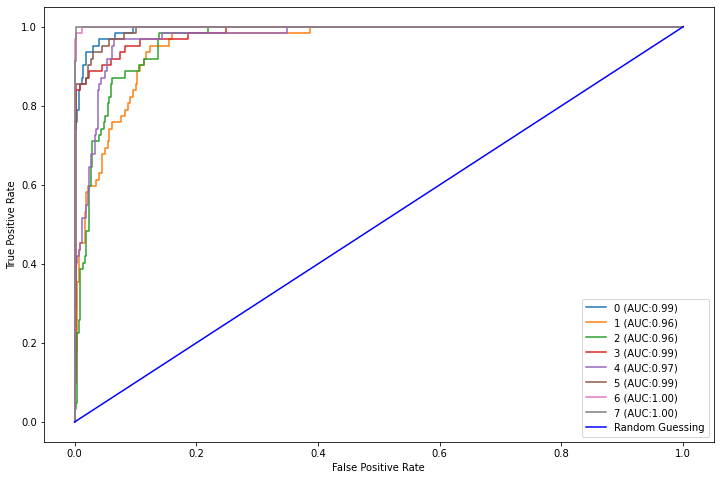

In [19]:
print('My 3.d:')
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):

    for idx in range(8):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (idx, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(t_label_batch, prediction_prob))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

Generate explanation map

## SISE (Semantic Input Sampling for Explanation)

Set the layer(s)

In [20]:
layers=[['conv2d_3']]

In [21]:
index=8

In [22]:
%%time
explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
explanation_map_SISE -= explanation_map_SISE.min()
explanation_map_SISE /= explanation_map_SISE.max()+10e-30

CPU times: user 4.1 s, sys: 86.6 ms, total: 4.19 s
Wall time: 2.36 s


## Grad-CAM (Gradient-based Class Activation Mapping)

In [23]:
%%time
explanation_map_GradCAM = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
explanation_map_GradCAM -= explanation_map_GradCAM.min()
explanation_map_GradCAM /= explanation_map_GradCAM.max()+10e-30

CPU times: user 627 ms, sys: 20 ms, total: 647 ms
Wall time: 458 ms


In [24]:
# grad cam ++
%%time
explanation_map_GradCAM_plus = grad_cam_plus(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
explanation_map_GradCAM_plus -= explanation_map_GradCAM_plus.min()
explanation_map_GradCAM_plus /= explanation_map_GradCAM_plus.max()+10e-30

CPU times: user 564 ms, sys: 28 ms, total: 592 ms
Wall time: 427 ms


## RISE (Randomized Input Sampling for Explanation)

In [25]:
%%time
explanation_map_RISE = RISE(image_batch[index], model, class_index=np.argmax(prediction[index]) ,N_MASKS=1000)
explanation_map_RISE -= explanation_map_RISE.min()
explanation_map_RISE /= explanation_map_RISE.max()+10e-30

CPU times: user 1min 31s, sys: 800 ms, total: 1min 32s
Wall time: 52.4 s


## Plot the results

In [26]:
test_generator.reset()
image_batch,label_batch=test_generator.next()

Text(0.5, 1.0, 'Explanation map (Grad-CAM++)')

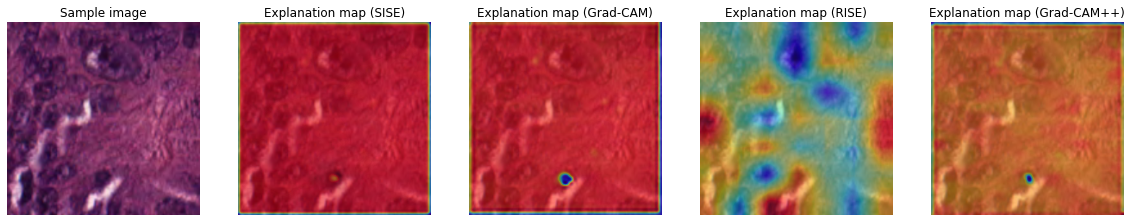

In [27]:
#@title Plot the results

plt.figure(figsize=(20,5))

plt.subplot(1,5,1)
plt.imshow(image_batch[index])
plt.axis('off')
plt.title('Sample image')

plt.subplot(1,5,2)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_SISE, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (SISE)')

plt.subplot(1,5,3)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_GradCAM, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Grad-CAM)')

plt.subplot(1,5,4)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_RISE, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (RISE)')

plt.subplot(1,5,5)
plt.imshow(image_batch[index])
plt.imshow(explanation_map_GradCAM_plus, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title('Explanation map (Grad-CAM++)')

True label: Empty
Predicted_label: Empty
Confidence score for the correct label: 0.904856


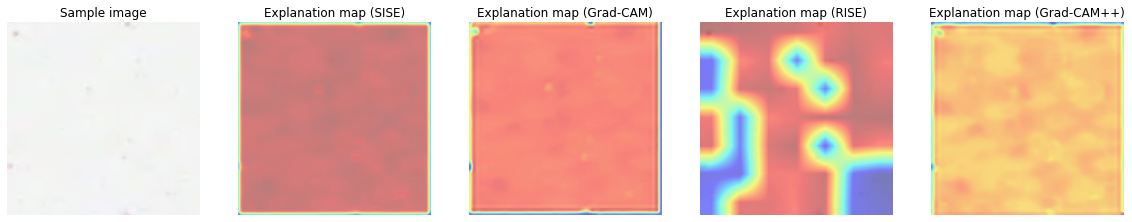

In [39]:
def my_XAI_test(test_generator, batch_num, index, model):
    test_generator.reset()
    for i in range(batch_num):
        image_batch,label_batch=test_generator.next()

    prediction=model(image_batch)
    print('True label: '+classes[np.argmax(label_batch[index])])
    print('Predicted_label: '+classes[np.argmax(prediction[index])])
    print('Confidence score for the correct label: '+str(prediction[index][np.argmax(label_batch[index])].numpy()))

    explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
    explanation_map_SISE -= explanation_map_SISE.min()
    explanation_map_SISE /= explanation_map_SISE.max()+10e-30

    explanation_map_GradCAM = grad_cam(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
    explanation_map_GradCAM -= explanation_map_GradCAM.min()
    explanation_map_GradCAM /= explanation_map_GradCAM.max()+10e-30

    explanation_map_GradCAM_plus = grad_cam_plus(model, np.expand_dims(image_batch[index], axis=0), 'max_pooling2d_1')
    explanation_map_GradCAM_plus -= explanation_map_GradCAM_plus.min()
    explanation_map_GradCAM_plus /= explanation_map_GradCAM_plus.max()+10e-30

    explanation_map_RISE = RISE(image_batch[index], model, class_index=np.argmax(prediction[index]) ,N_MASKS=1000)
    explanation_map_RISE -= explanation_map_RISE.min()
    explanation_map_RISE /= explanation_map_RISE.max()+10e-30


    plt.figure(figsize=(20,5))

    plt.subplot(1,5,1)
    plt.imshow(image_batch[index])
    plt.axis('off')
    plt.title('Sample image')

    plt.subplot(1,5,2)
    plt.imshow(image_batch[index])
    plt.imshow(explanation_map_SISE, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title('Explanation map (SISE)')

    plt.subplot(1,5,3)
    plt.imshow(image_batch[index])
    plt.imshow(explanation_map_GradCAM, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title('Explanation map (Grad-CAM)')

    plt.subplot(1,5,4)
    plt.imshow(image_batch[index])
    plt.imshow(explanation_map_RISE, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title('Explanation map (RISE)')

    plt.subplot(1,5,5)
    plt.imshow(image_batch[index])
    plt.imshow(explanation_map_GradCAM_plus, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title('Explanation map (Grad-CAM++)')

my_XAI_test(test_generator, 15, 0, model)

True label: Tumor
Predicted_label: Tumor
Confidence score for the correct label: 0.9643945


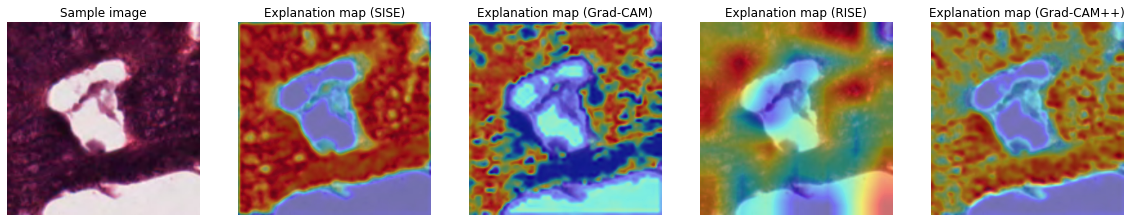

In [42]:
my_XAI_test(test_generator, 3, 15, model)

True label: Stroma
Predicted_label: Stroma
Confidence score for the correct label: 0.6776315


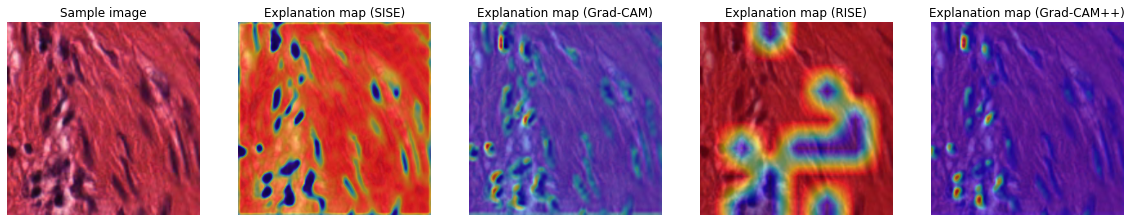

In [43]:
my_XAI_test(test_generator, 3, 15, model)

True label: Complex
Predicted_label: Complex
Confidence score for the correct label: 0.8046486


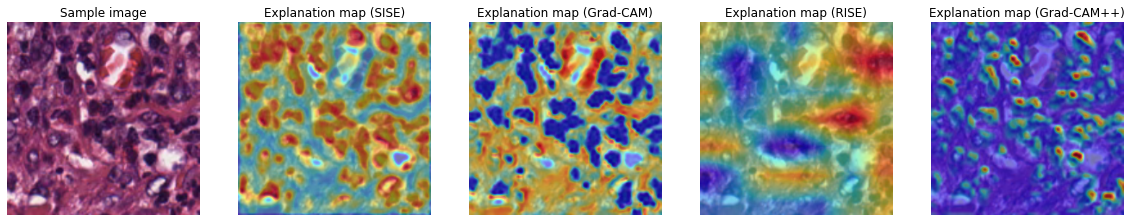

In [44]:
my_XAI_test(test_generator, 5, 15, model)

True label: Lympho
Predicted_label: Lympho
Confidence score for the correct label: 0.9826848


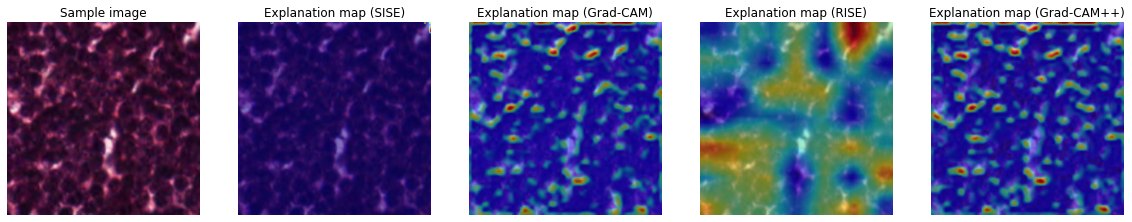

In [45]:
my_XAI_test(test_generator, 7, 15, model)

True label: Debris
Predicted_label: Debris
Confidence score for the correct label: 0.52064186


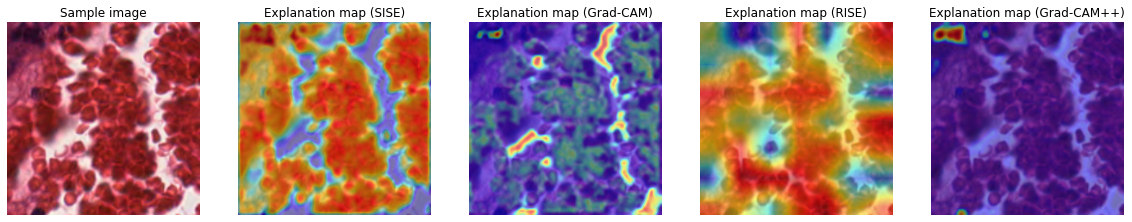

In [46]:
my_XAI_test(test_generator, 9, 15, model)

True label: Mucosa
Predicted_label: Mucosa
Confidence score for the correct label: 0.86029816


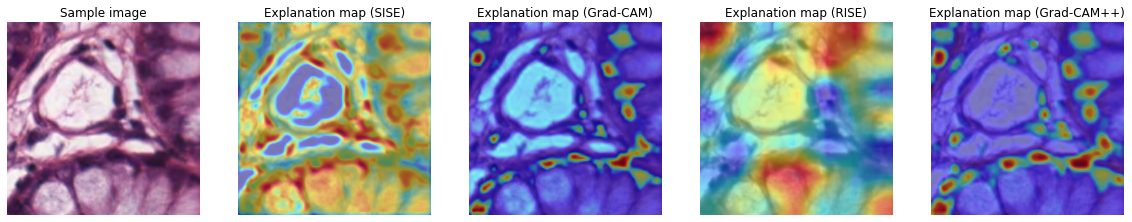

In [47]:
my_XAI_test(test_generator, 11, 15, model)

True label: Adiopse
Predicted_label: Adiopse
Confidence score for the correct label: 0.98310226


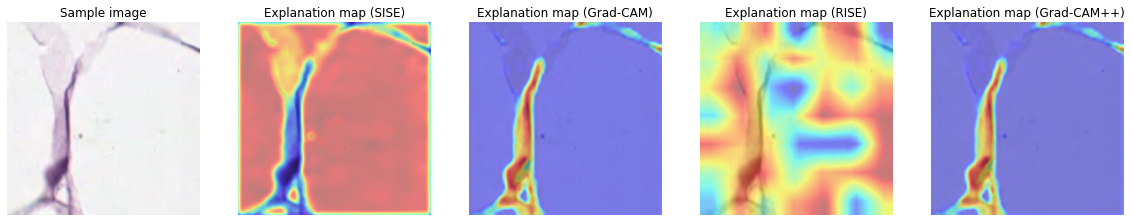

In [48]:
my_XAI_test(test_generator, 13, 15, model)

## Quantitative evaluation of the explanation algorithm

In [28]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    # Pre-processing image 
    img=images[0,:,:,:]
    img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,224,224,3))
    exmap1_thr[0,:,:,0]=img[0,:,:,0]*exmap1_msk
    exmap1_thr[0,:,:,1]=img[0,:,:,1]*exmap1_msk
    exmap1_thr[0,:,:,2]=img[0,:,:,2]*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [29]:
test_generator.reset()
sise_drop_rate = 0.
sise_inc_rate = 0.
for _ in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        explanation_map_SISE = SISE(np.expand_dims(image_batch[index], axis=0), model, layers=layers, class_index=np.argmax(prediction[index]), grad_thr=0.)
        arr = calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_SISE, class_index=np.argmax(prediction[index]), frac=0.9)
        sise_drop_rate += arr[0]
        sise_inc_rate += arr[1]
# drop_rate /= (15*32)
sise_drop_rate /= (15*32)
sise_inc_rate /= (15*32)

In [30]:
print("SISE drop rate is:", sise_drop_rate)
print("SISE increase rate is:", sise_inc_rate)

SISE drop rate is: 0.597733672715074
SISE increase rate is: 0.17916666666666667


In [31]:
test_generator.reset()
grad_cam_plus_drop_rate = 0.
grad_cam_plus_inc_rate = 0.
for _ in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        explanation_map_Grad_CAM_plus = grad_cam_plus(model, np.expand_dims(image_batch[index], axis=0), layer_name=layers[0][0])
        arr = calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_Grad_CAM_plus, class_index=np.argmax(prediction[index]), frac=0.9)
        grad_cam_plus_drop_rate += arr[0]
        grad_cam_plus_inc_rate += arr[1]
# drop_rate /= (15*32)
grad_cam_plus_drop_rate /= (15*32)
grad_cam_plus_inc_rate /= (15*32)

In [32]:
grad_cam_plus(model, np.expand_dims(image_batch[0], axis=0), layer_name=layers[0][0])

array([[0.14107232, 0.1661656 , 0.20816132, ..., 0.20006458, 0.17784965,
        0.16659601],
       [0.16198075, 0.1980091 , 0.26215047, ..., 0.26298174, 0.22055991,
        0.20024632],
       [0.22283666, 0.28045195, 0.38706076, ..., 0.40629587, 0.32587036,
        0.2878217 ],
       ...,
       [0.41296604, 0.48887563, 0.63036644, ..., 0.7258805 , 0.6816857 ,
        0.66979855],
       [0.4393972 , 0.5103103 , 0.64038235, ..., 0.7140918 , 0.68573654,
        0.683868  ],
       [0.4533518 , 0.5221    , 0.64685726, ..., 0.7051902 , 0.68063056,
        0.68100363]], dtype=float32)

In [33]:
print("Grad-CAM++ drop rate is:", grad_cam_plus_drop_rate)
print("Grad-CAM++ increase rate is:", grad_cam_plus_inc_rate)

Grad-CAM++ drop rate is: 0.622972619589382
Grad-CAM++ increase rate is: 0.24583333333333332


In [34]:
test_generator.reset()
grad_cam_plus_drop_rate = 0.
grad_cam_plus_inc_rate = 0.
for _ in range(15):
    image_batch,label_batch=test_generator.next()
    for index in range(32):
        prediction=model(image_batch)
        explanation_map_Grad_CAM_plus = grad_cam_plus(model, np.expand_dims(image_batch[index], axis=0), layer_name='max_pooling2d_1')
        arr = calculate_drop_increase(np.expand_dims(image_batch[index], axis=0), model, explanation_map_Grad_CAM_plus, class_index=np.argmax(prediction[index]), frac=0.9)
        grad_cam_plus_drop_rate += arr[0]
        grad_cam_plus_inc_rate += arr[1]
# drop_rate /= (15*32)
grad_cam_plus_drop_rate /= (15*32)
grad_cam_plus_inc_rate /= (15*32)

In [ ]:
print("Grad-CAM++ drop rate is:", grad_cam_plus_drop_rate)
print("Grad-CAM++ increase rate is:", grad_cam_plus_inc_rate)